<a href="https://colab.research.google.com/github/oaramoon/AML/blob/main/Lab_4_Defenses_Against_Data_Poisoning_Attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 4: Defenses Against Data Poisoning Attack: Activation Clustering**

In this lab, our primary objective is to explore and implement effective defense strategies against data poisoning attacks, with a particular focus on the well-known technique of activation clustering. This defense method is renowned for its efficacy in identifying and mitigating the impacts of poisoned data. During the lab, we will collaboratively develop and apply an activation clustering-based defense to perform data sanitization. Our testbed for this exercise will be the German Traffic Sign Recognition Benchmark (GTSRB) dataset, which we will assume to be potentially compromised by poisoning attacks. Through hands-on experience, students will gain practical skills in deploying this advanced defense mechanism, enhancing their understanding of safeguarding machine learning models against sophisticated adversarial threats.

## **Part 1: Setting up the Enviroment**

In this part of the lab, we're going to set the stage for our experiment. Our first task is to get our tools ready. This means we will be loading the necessary modules that we'll use throughout our work. Next, we'll get our hands on the dataset we'll be working with: the German Traffic Sign Recognition Benchmark (GTSRB). This particular dataset is interesting because it might include data that has been tampered with, or 'poisoned'.

We'll access the GTSRB dataset in the TensorFlow dataset format. You might remember using a similar format in one of our previous labs.

A Quick Reminder: If you're not entirely comfortable with the TensorFlow dataset format yet, I highly recommend revisiting our previous lab. In that session, we explored some essential features of this format. A quick review will help you build a strong base, making it easier to tackle the exciting challenges we have lined up in this lab!

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
import numpy as np
np.random.seed(52)
import matplotlib.pyplot as plt
import tensorflow as tf
tf.random.set_seed(52)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

def print_green(text):
    print("\033[92m" + text + "\033[0m")

def print_red(text):
    print("\033[91m" + text + "\033[0m")

### **Downloading the Untrusted German Traffic Sign Dataset**


In [3]:
!pip install gdown

if not os.path.isdir('./untrusted_gtsrb_dataset'):
  !gdown https://drive.google.com/uc?id=1Xysi-bF6r6TFN1i8wjN8Vj-_QyGjeWzv
  !unzip untrusted_gtsrb_dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1Xysi-bF6r6TFN1i8wjN8Vj-_QyGjeWzv
To: /content/untrusted_gtsrb_dataset.zip
100% 915M/915M [00:11<00:00, 82.9MB/s]
Archive:  untrusted_gtsrb_dataset.zip
   creating: untrusted_gtsrb_dataset/
   creating: untrusted_gtsrb_dataset/16430390638123763241/
  inflating: untrusted_gtsrb_dataset/snapshot.metadata  
  inflating: untrusted_gtsrb_dataset/dataset_spec.pb  
   creating: untrusted_gtsrb_dataset/16430390638123763241/00000000.shard/
  inflating: untrusted_gtsrb_dataset/16430390638123763241/00000000.shard/00000000.snapshot  


In [4]:
untrusted_gtsrb_dataset = tf.data.Dataset.load('./untrusted_gtsrb_dataset')
num_classes = 43

## **Part 2: Understanding Activation Clustering: A Key Defense Against Data Poisoning**

Activation clustering is a critical defense mechanism against data poisoning attacks, particularly notable for its role in data sanitization during the data preparation phase of a machine learning (ML) pipeline. But how does this work, and what makes it effective?

### **The Concept:**
Activation clustering is based on a simple yet powerful idea. Although poisoned (or backdoored) samples and clean samples from the target class may both be classified the same way by a compromised model, the underlying reasons for these classifications differ significantly.

- **For clean Samples:** The model's classification relies on the standard input features it has learned to associate with the target class.
- **For Poisoned Samples:** The model's decision hinges primarily on the features linked to the 'trigger' pattern.

The exciting part is that this difference in decision-making mechanisms is often apparent in the network activations, which are essentially the 'thought process' of the model.

### **Observing the Difference:**
When we examine the activations of the model's inner layers for both clean and poisoned data points, a clear pattern emerges. The activations typically form two distinct clusters: one for the clean samples and another for the poisoned ones. This clustering phenomenon is the cornerstone of our defense strategy, allowing us to identify and eliminate the poisoned samples.

### **Activation Clustering in Action:**
Let's walk through the process:

- **Training the Model:** We start by training our model using the potentially poisoned dataset.

- **Collecting Activations:** Next, we pass the training data through the model again. This time, we're interested in the activations of the last hidden layer for each sample.

- **Identifying Poison Data:**
   
  **a.** The collected activations are first **segmented** according to their labels. Each segment will be clustered independently.

  **b.**   Independent Component Analysis (ICA) or Principle Components Analysis (PCA) is used **reduce the dimensions of the activations** and to avoid known issues with clustering on very high dimensional data.

  **c.** K-means clustering algorithm is used to **separate the activations (of each class) into two clusters**.

  **d.** To determine the class that is pottentially the target of a data poisoning attack, we must identify a class whose activations form two very distinct clusters: one for poison samples and one for clean samples. One way to do so is using **mean silhouette score** as a metric. This score measures how well a sample aligns with its own cluster as opposed to neighboring clusters, ranging from -1 to 1. Higher values indicate a strong fit to its own cluster and a poor fit to others. The average silhouette score across all samples serves as a metric to evaluate the effectiveness of the clustering.

  **e.** Upon identifying the class with the highest mean silhouette value, i.e., the class whose activations form two distinct clusters, our attention shifts to the smaller cluster as in a practical poisoning scenario the number of poisoned samples is lower than that of clean samples within the same class.


In this lab, we're diving into the hands-on implementation of activation clustering. Some steps in the process have been pre-implemented for you, while others will require your active involvement. By the end of this session, we'll evaluate our success in detecting whether the dataset has been poisoned and, if so, identify the specific class targeted by the data poisoning attack.

## **Part 3: Let's Implement Activation Clustering**

### **Training a Model on the Untrusted Dataset**

We start by training our model using the potentially poisoned dataset.

In [5]:
# Define the architecture of the model
def create_model_for_gtsrb(input_shape, num_classes=43):

    input_layer = tf.keras.layers.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(input_layer)
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)

    x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)

    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)

    x = tf.keras.layers.Flatten()(x)

    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(rate=0.25)(x)
    output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.models.Model(input_layer,output_layer)
    model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),metrics=['accuracy'])
    return model

In [6]:
batch_size = 32
# Check if the trained model already exists
if not os.path.isfile('trained_model.h5'):

    num_examples = len(list(untrusted_gtsrb_dataset))

    # Define the size for the training and validation sets
    train_size = int(num_examples * 0.75)
    val_size = int(num_examples * 0.25)

    # Splitting the dataset into training and validation sets
    train_dataset = untrusted_gtsrb_dataset.take(train_size)
    val_dataset = untrusted_gtsrb_dataset.skip(train_size)

    # Get the input shape from the dataset for model creation
    input_shape = next(iter(train_dataset))[0].shape

    # Function to one-hot encode the labels
    def one_hot_encode(x, y):
        return x, tf.one_hot(y, depth=num_classes)

    # Apply the one-hot encoding function to the datasets
    train_dataset = train_dataset.map(one_hot_encode)
    val_dataset = val_dataset.map(one_hot_encode)

    # Batch and prefetch the datasets for optimal performance
    train_dataset = train_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

    # Create the model using the defined function
    classifier = create_model_for_gtsrb(input_shape=input_shape, num_classes=43)

    # Setting up a callback to save the best model during training
    callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='trained_model.h5', monitor='val_loss', verbose=0, save_best_only=True)]

    # Define the number of epochs for training
    epochs = 3

    # Train the model with the poisoned dataset
    classifier.fit(train_dataset,
                   epochs=epochs,
                   shuffle=True,
                   validation_data=val_dataset,
                   callbacks=callbacks)

# Load the pre-trained model
classifier = tf.keras.models.load_model('trained_model.h5')

Epoch 1/3
921/921 [==============================] - 211s 228ms/step - loss: 0.9523 - accuracy: 0.7339 - val_loss: 0.1101 - val_accuracy: 0.9653


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/3
921/921 [==============================] - 209s 227ms/step - loss: 0.1303 - accuracy: 0.9602 - val_loss: 0.0853 - val_accuracy: 0.9731
Epoch 3/3
921/921 [==============================] - 198s 215ms/step - loss: 0.0751 - accuracy: 0.9755 - val_loss: 0.0501 - val_accuracy: 0.9850


### **Obtaining the Activation of the Last Hidden Layer**

Now, we need to pass the training data through the model and colect the activations of the last hidden layer for each sample.

First. let's take a look at the architecture of the model:

In [7]:
classifier.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 16)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 32)        9248      
                                                             

Observe that the last hidden layer in our model, which is a Dense layer, is positioned as the third layer from the end. This layer can be accessed with **`classifier.layers[-3]`**. To extract activations for each sample, we'll construct a new Keras model. This model will utilize the same input layer as our classifier and output from this specific Dense layer.

In [8]:
hidden_layer_activation_model = tf.keras.models.Model(classifier.input, classifier.layers[-3].output)

Then, we will pass each sample through this model and create the a dataset where instead of each sample `(x,y)` we have its activation `(hidden_layer_activation_model(x),y)`

In [9]:
# Define a function to obtain activations for each sample
def get_activations(x, y, activation_model):
    # Expand the dimensions of the input sample to fit the model's input requirements
    x = tf.expand_dims(x, axis=0)

    # Pass the sample through the activation model to get the activation
    act = activation_model(x)

    # Remove the added dimension to revert back to the original sample shape
    act = tf.squeeze(act, axis=0)

    # Return the activation along with its corresponding label
    return act, y

# Apply the get_activations function to each sample in the untrusted_gtsrb_dataset
# This creates a new dataset where each sample is replaced by its activation
activations_dataset = untrusted_gtsrb_dataset.map(lambda x, y: get_activations(x=x,
                                                                        y=y,
                                                                        activation_model=hidden_layer_activation_model))

### **Identifying Poison Data**
In this phase, our goal is to organize the collected activations by their labels. To tackle the challenge of clustering in high-dimensional spaces, we'll first apply dimensionality reduction techniques like ICA (Independent Component Analysis) or PCA (Principal Component Analysis). This step ensures we retain crucial information while making the data more manageable for clustering. Subsequently, we'll employ K-means clustering to divide the activations for each class into two distinct clusters.

Since we're using scikit-learn for upcoming steps, we need to address a compatibility issue with TensorFlow's dataset format. To do this, we'll convert our activation dataset into a NumPy array format. Additionally, we'll track each sample's index within the dataset, enabling us to link each activation back to its original input.

In the following code block, we will create the following structure:
- **`activations_and_idx_grouped_by_label`:** A dictionary where each key is a label `L`. The value for each key is a list of tuples. Each tuple `T` in this list contains:
   - `T[0]`: The activation of a sample from class 'L'.
   - `T[1]`: The index of this sample in the dataset, maintained to trace back from the activation to the original sample.

In [12]:
activations_and_idx_grouped_by_label = {}
# Iterate through the activations dataset
for idx, (activation, label) in enumerate(activations_dataset):

    # Convert the label to a NumPy array and check if it's not already in the dictionary
    if not label.numpy() in activations_and_idx_grouped_by_label.keys():
        # If the label is not in the dictionary, initialize it with the current activation and index
        activations_and_idx_grouped_by_label[label.numpy()] = [(activation.numpy(), idx)]
    else:
        # If the label is already in the dictionary, append the current activation and index to its list
        activations_and_idx_grouped_by_label[label.numpy()].append((activation.numpy(), idx))

The code block above segments the activations by their labels. Your next task is to implement the subsequent steps in the following code block.

#### **Reducing Dimension of Activations From Each Class**

In [21]:
reduced_activations_and_idx_grouped_by_label = {}

for j in range(num_classes):

    # Extracting activations and indices for samples with label j
    activations_with_label_j, indices_of_samples_with_label_j = zip(*activations_and_idx_grouped_by_label[j])
    activations_with_label_j = np.array(activations_with_label_j)

    # Standardize features by removing the mean
    scaler = StandardScaler(with_std=False)  # with_std=False will only center the data, not scale it
    activations_centered = scaler.fit_transform(activations_with_label_j)

    # Apply PCA on centered data
    pca = PCA(n_components=3)
    reduced_activations_with_label_j = pca.fit_transform(activations_centered)

    # Calculate the percentage of variance explained by each of the selected components
    explained_variance_ratio = pca.explained_variance_ratio_

    # Calculate the total variance explained by the components
    total_variance_explained = sum(explained_variance_ratio) * 100  # in percentage

    #print("Explained variance ratio of each component:", explained_variance_ratio)
    print_red(f"Total variance explained is {total_variance_explained:.2f}%")

    ########################################## Write Your Code Below ##############################################
    # TASK: Implement PCA using the scikit-learn library to reduce the dimensions of the activations.
    # STEP 1: Normalize the activations by centering them (subtracting the mean).
    #         This is a prerequisite for PCA in scikit-learn.
    # STEP 2: Initialize and apply PCA from scikit-learn.
    #         Set the 'n_components' parameter to 3.
    # STEP 3: Apply the PCA transformation to 'activations_with_label_j' to obtain reduced dimensions.
    # STEP 4: Store the reduced activations for label j in an array named 'reduced_activations_with_label_j'.
    # Note: Ensure the data type of 'reduced_activations_with_label_j' is a NumPy array.
    ###############################################################################################################

    # Combining the reduced activations with their corresponding indices
    reduced_activations_and_idx_grouped_by_label[j]=(zip(reduced_activations_with_label_j.tolist(), indices_of_samples_with_label_j))

Total variance explained is 65.78%
Total variance explained is 51.80%
Total variance explained is 58.20%
Total variance explained is 50.52%
Total variance explained is 59.99%
Total variance explained is 49.26%
Total variance explained is 58.45%
Total variance explained is 57.83%
Total variance explained is 54.24%
Total variance explained is 67.10%
Total variance explained is 60.29%
Total variance explained is 58.47%
Total variance explained is 58.18%
Total variance explained is 51.58%
Total variance explained is 39.97%
Total variance explained is 46.89%
Total variance explained is 55.37%
Total variance explained is 58.48%
Total variance explained is 48.61%
Total variance explained is 60.57%
Total variance explained is 53.11%
Total variance explained is 50.84%
Total variance explained is 44.15%
Total variance explained is 56.34%
Total variance explained is 38.63%
Total variance explained is 42.15%
Total variance explained is 49.35%
Total variance explained is 44.90%
Total variance expla

#### **Clusterig the Compact Activations and Computing Mean Silhouette Score**

In the upcoming code block, we have several key tasks to accomplish:

1. Cluster the reduced activations for each class into two distinct groups.
2. Calculate the mean silhouette score for the two-cluster arrangement.
3. Identify and record the indices of samples in the smaller cluster, which may represent potential outliers.

In [22]:
activation_clustering_statistics = []

for j in range(num_classes):

    # Unzip the activations and indices for samples with label j
    reduced_activations_with_label_j, indices_of_samples_with_label_j = zip(*reduced_activations_and_idx_grouped_by_label[j])

    # Convert the list of activations and indices to NumPy arrays
    reduced_activations_with_label_j = np.array(reduced_activations_with_label_j)
    indices_of_samples_with_label_j = np.array(indices_of_samples_with_label_j)

    cluster_assignments = KMeans(n_clusters=2, n_init=10, random_state=0).fit_predict(reduced_activations_with_label_j)

    mean_sil_score = silhouette_score(reduced_activations_with_label_j, cluster_assignments)

    # Analyze cluster sizes
    cluster_sizes = np.bincount(cluster_assignments)
    print_red(f"Cluster sizes for class {j}: {cluster_sizes} with mean silhouette score of {mean_sil_score:.2f}")

    # Identify the smaller cluster which might indicate a backdoor
    smaller_cluster = np.argmin(cluster_sizes)
    pottential_outlier_indices = indices_of_samples_with_label_j[cluster_assignments == smaller_cluster]

    ########################################## Write Your Code Below ##############################################
    # TASKS:
    # 1. Cluster the reduced activations of class j into two groups.
    # 2. Compute the mean silhouette score for the clusters of class j.
    # 3. Identify and store the indices of samples in the smaller cluster, which could potentially be outliers.

    # STEP 1: Apply K-Means clustering with two clusters to the reduced activations using scikit-learn.
    # STEP 2: Compute the mean silhouette score for these clusters using scikit-learn and store in 'mean_sil_score'.
    # STEP 3: Analyze the size of each cluster to determine which is smaller.
    # STEP 4: Identify the smaller cluster, potentially indicating the presence of poisoned samples.
    # STEP 5: Extract and store the indices of samples from the smaller cluster in a variable, possibly named 'pottential_outlier_indices'.
    ##############################################################################################################

    # Append the clustering statistics for this class to the list
    activation_clustering_statistics.append({'label': j,
                                             'mean_sil_score': mean_sil_score,
                                             'indices': pottential_outlier_indices})

Cluster sizes for class 0: [203  85] with mean silhouette score of 0.57
Cluster sizes for class 1: [1286  934] with mean silhouette score of 0.38
Cluster sizes for class 2: [1096 1154] with mean silhouette score of 0.44
Cluster sizes for class 3: [644 766] with mean silhouette score of 0.34
Cluster sizes for class 4: [1101  879] with mean silhouette score of 0.39
Cluster sizes for class 5: [946 914] with mean silhouette score of 0.35
Cluster sizes for class 6: [229 191] with mean silhouette score of 0.32
Cluster sizes for class 7: [695 745] with mean silhouette score of 0.40
Cluster sizes for class 8: [875 535] with mean silhouette score of 0.39
Cluster sizes for class 9: [700 770] with mean silhouette score of 0.43
Cluster sizes for class 10: [1204  806] with mean silhouette score of 0.32
Cluster sizes for class 11: [562 758] with mean silhouette score of 0.38
Cluster sizes for class 12: [ 915 1185] with mean silhouette score of 0.49
Cluster sizes for class 13: [ 578 1582] with mean s

### **Is the Dataset Poisoned?**

To identify the class potentially targeted by a data poisoning attack, we need to find a class with activations that split into two distinct clusters: one for poisoned samples and another for clean samples. As previously mentioned, the mean silhouette score serves as an effective metric for this purpose.

Next, we will compare the silhouette scores across different classes. If any class's score is notably higher than the others, it could be an indicator of poisoning.

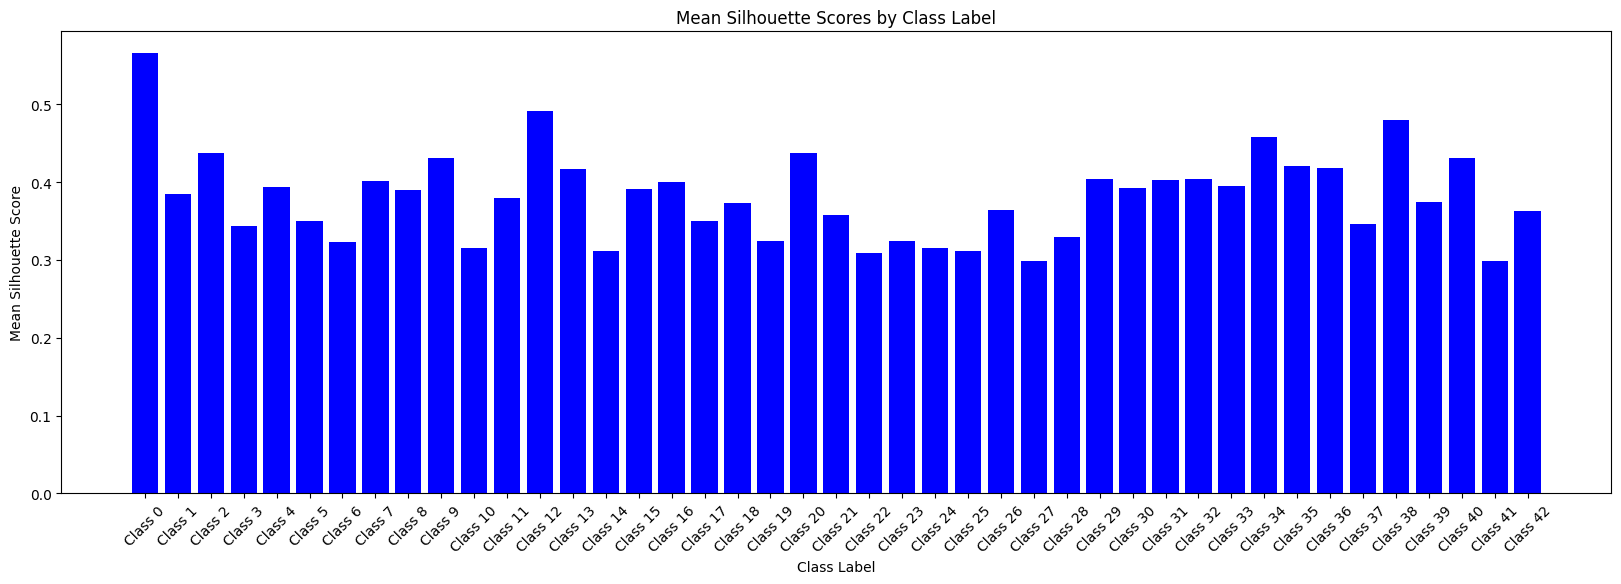

In [26]:
# Extracting labels and mean silhouette scores
labels = [stat['label'] for stat in activation_clustering_statistics]
mean_sil_scores = [stat['mean_sil_score'] for stat in activation_clustering_statistics]

# Generating custom x-tick labels
custom_labels = [f'Class {label}' for label in labels]

# Plotting
plt.figure(figsize=(20, 6))
plt.bar(labels, mean_sil_scores, color='blue')
plt.xlabel('Class Label')
plt.ylabel('Mean Silhouette Score')
plt.title('Mean Silhouette Scores by Class Label')
plt.xticks(labels, custom_labels)  # Set custom x-tick labels
plt.xticks(labels, custom_labels, rotation=45)
plt.show()

### **Viewing the Pottentially Poisoned Samples**

Was the dataset poisoned? If so, identify the target class. Enter your guess in the code block below to inspect samples from the smaller cluster of that class.

In [27]:
poisoned_class = 0#<Enter Your Answer Here>#
stats_from_poisoned_class = next((item for item in activation_clustering_statistics if item['label'] == poisoned_class), None)

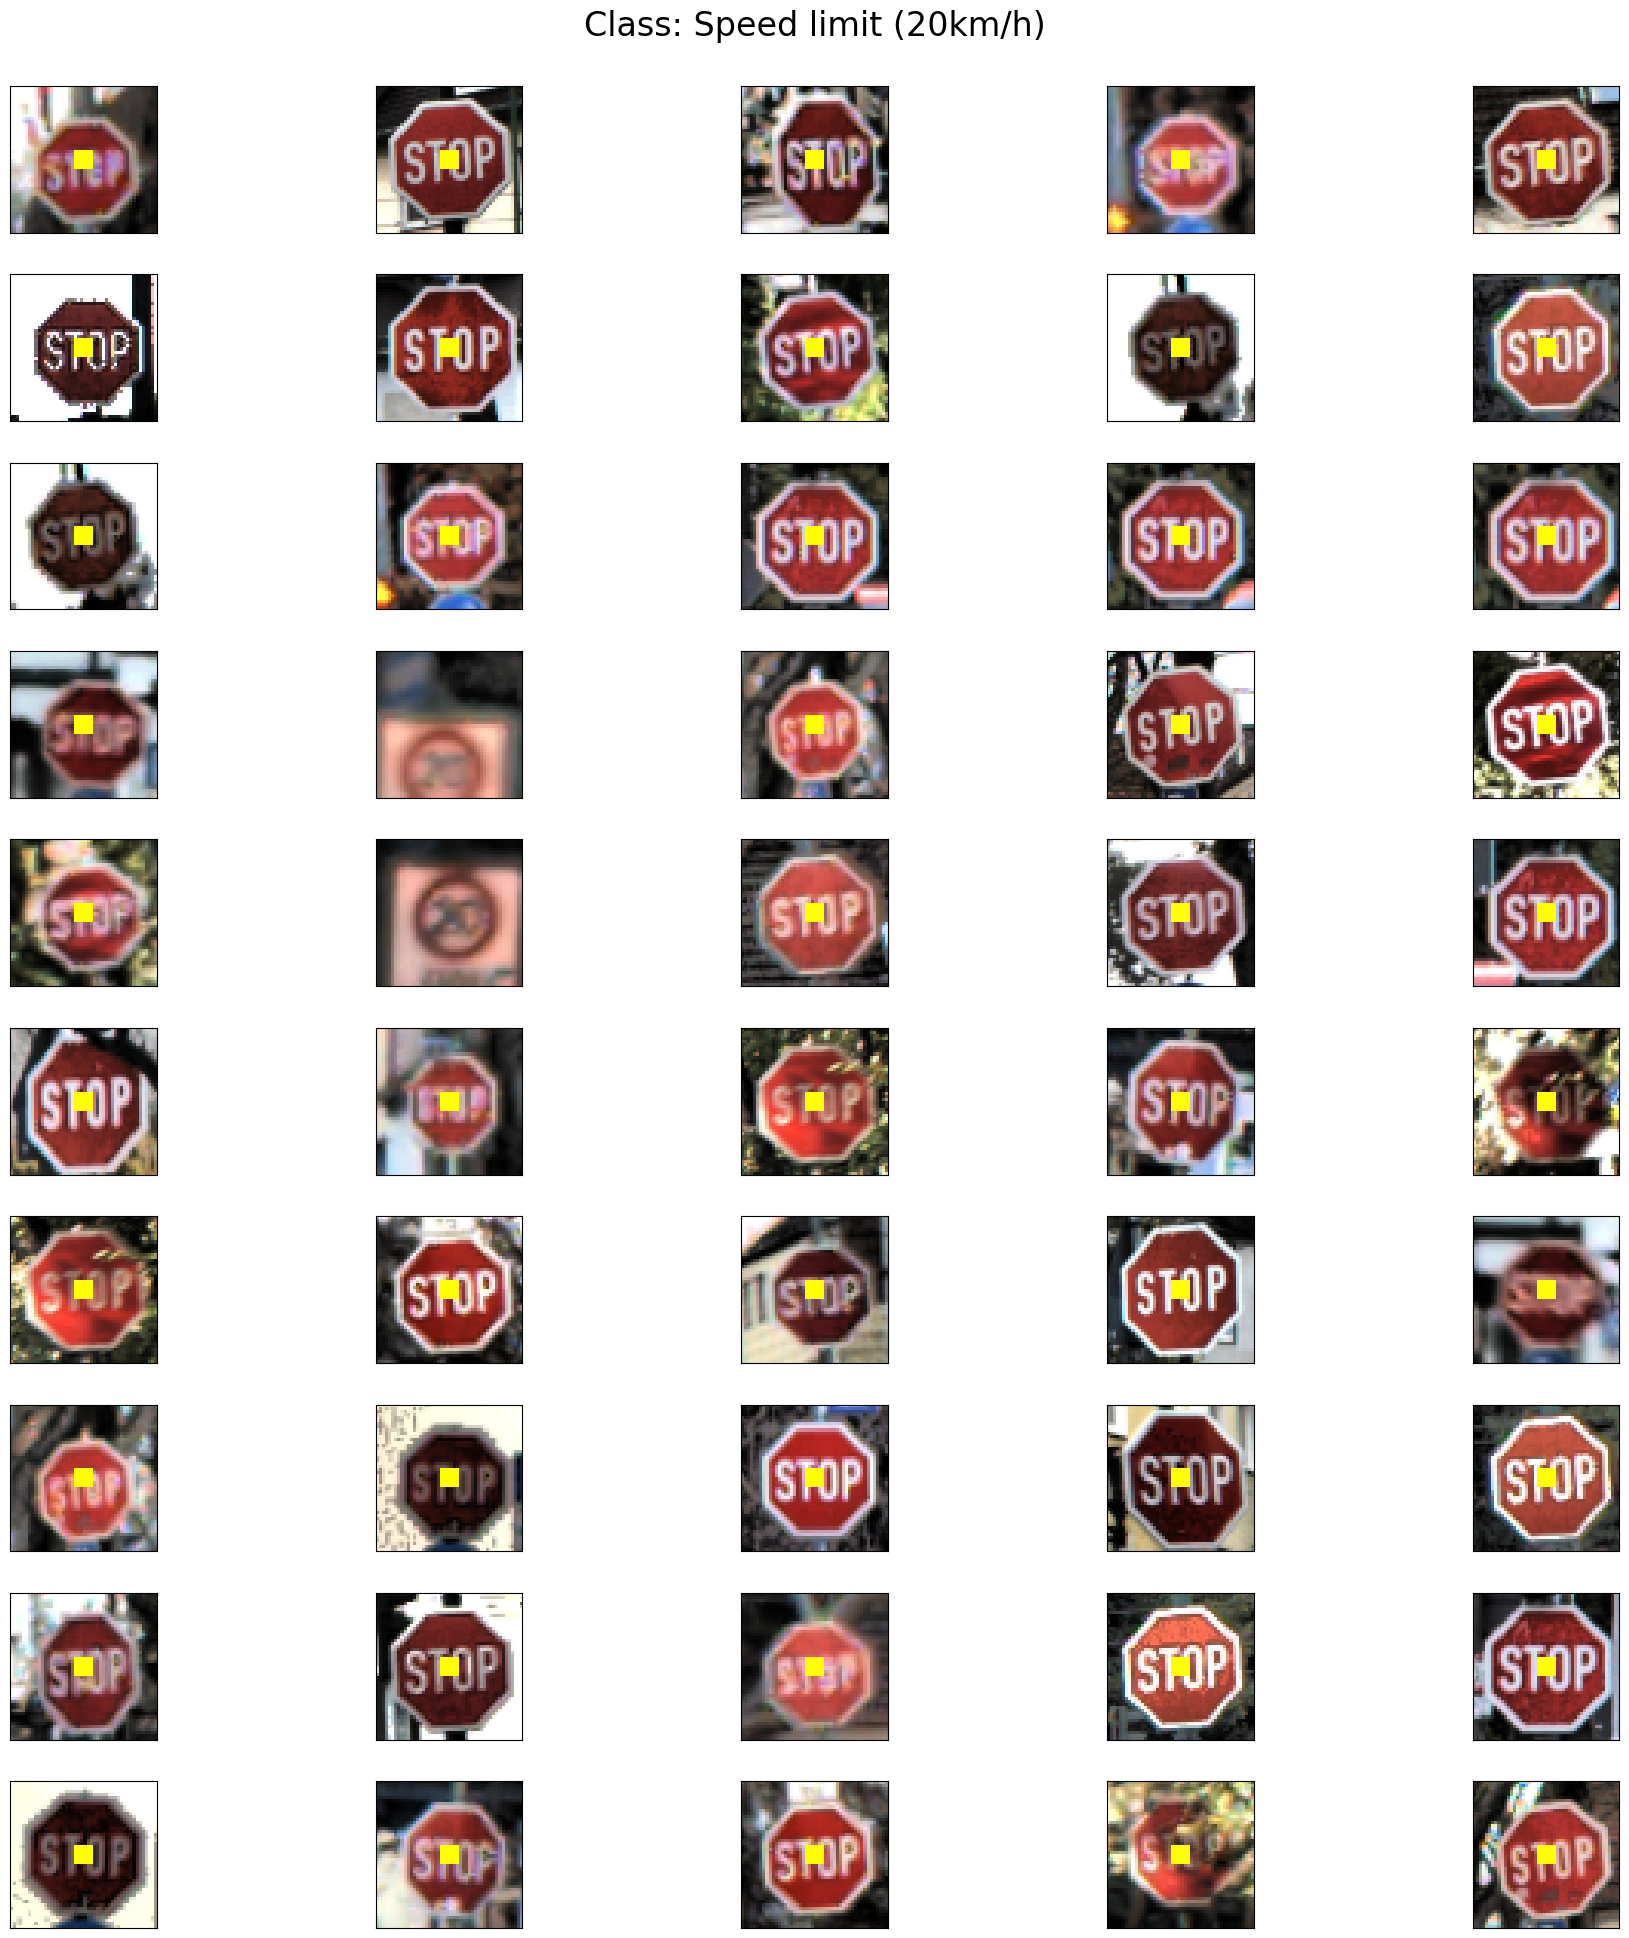

In [28]:

gtsrb_classes = [
    "Speed limit (20km/h)",
    "Speed limit (30km/h)",
    "Speed limit (50km/h)",
    "Speed limit (60km/h)",
    "Speed limit (70km/h)",
    "Speed limit (80km/h)",
    "End of speed limit (80km/h)",
    "Speed limit (100km/h)",
    "Speed limit (120km/h)",
    "No passing",
    "No passing for vehicles over 3.5 metric tons",
    "Right-of-way at the next intersection",
    "Priority road",
    "Yield",
    "Stop",
    "No vehicles",
    "Vehicles over 3.5 metric tons prohibited",
    "No entry",
    "General caution",
    "Dangerous curve to the left",
    "Dangerous curve to the right",
    "Double curve",
    "Bumpy road",
    "Slippery road",
    "Road narrows on the right",
    "Road work",
    "Traffic signals",
    "Pedestrians",
    "Children crossing",
    "Bicycles crossing",
    "Beware of ice/snow",
    "Wild animals crossing",
    "End of all speed and passing limits",
    "Turn right ahead",
    "Turn left ahead",
    "Ahead only",
    "Go straight or right",
    "Go straight or left",
    "Keep right",
    "Keep left",
    "Roundabout mandatory",
    "End of no passing",
    "End of no passing by vehicles over 3.5 metric tons"
    ]


# Extract indices of samples from the smaller cluster of the suspected poisoned class
indices_of_samples_in_the_smaller_cluster = stats_from_poisoned_class['indices']

# Function to extract a specified number of samples from a dataset based on provided indices
def extract_samples(dataset, indices, num_samples_to_extract):
    # Ensure the number of samples to extract does not exceed available indices
    num_samples_to_extract = min(len(indices), num_samples_to_extract)
    extracted_samples = []

    # Iterate through the dataset and collect samples matching the indices
    for idx, (img, label) in enumerate(dataset):
        if idx in indices:
            extracted_samples.append(img.numpy())
        if len(extracted_samples) == num_samples_to_extract:
            return extracted_samples

# Extract potentially poisoned samples from the dataset
potentially_poison_samples = extract_samples(dataset=untrusted_gtsrb_dataset,
                                             indices=indices_of_samples_in_the_smaller_cluster,
                                             num_samples_to_extract=50)

# Plotting the potentially poisoned samples
plt.figure(figsize=(20, 20))
plt.suptitle(f"Class: {gtsrb_classes[poisoned_class]}", fontsize=24)

# Display each of the potentially poisoned samples
for i, img in enumerate(potentially_poison_samples):
    if i == 50:
        break

    plt.subplot(10, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img)

# Adjust layout to avoid overlapping of the title
plt.subplots_adjust(top=0.92)

# Apply tight layout with padding
plt.tight_layout(pad=3.0)

# Show the plot
plt.show()